In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor.EKF import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.simulator.atmos import AtmosphereModel
from deorbit.observer.observer import Observer


In [2]:
save_path = "eg/EKF_example_noise/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    sim = deorbit.simulator.run(
        "adams_bashforth",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.01}, "impulse": {"impulse_strength": 0.1, "impulse_probability": 1e-5}},
        time_step=0.1,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


In [12]:
obs = Observer(number_of_radars=3)
obs.states = sim_data.state_array()
obs.times = sim_data.times

obs.run(5000)

observation_times = obs.observed_times
observation_states = obs.observed_states
#print(observation_times.round())
#print(sim_data.times[:100])
#print(sim_data.x1[25000])

observations = (observation_states, observation_times.round())
#print(len(observation_states))

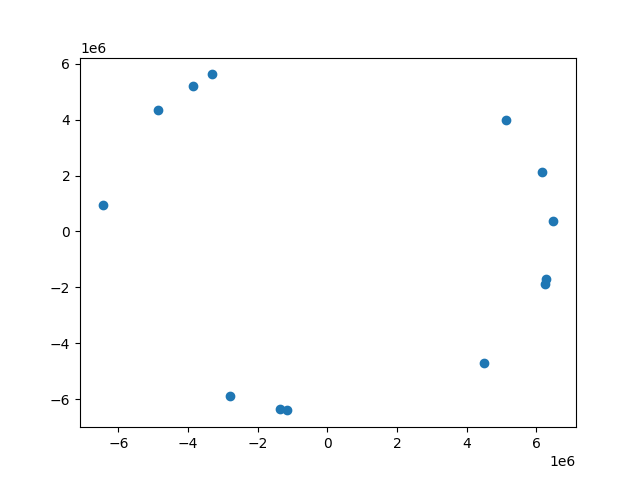

In [13]:
fig, ax = plt.subplots()

ax.scatter(observation_states[:, 0], observation_states[:, 1])
#earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
#ax.add_patch(earth)
#why when add more radars do you get more radar readings?? -- thought that it just took reading from closest radar??

In [14]:
# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.01, 0.01])#process noise
R = np.diag([1, 1, 0.1, 0.1]) #measurement noise
P = np.diag([1, 1, 1, 1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

dt = sim_config.simulation_method_kwargs.time_step
atmos_config = sim_config.atmosphere_model_kwargs

atmos = AtmosphereModel(atmos_config)

estimated_traj, measurements = EKF(sim_data, sim_config, atmos, dt, Q, R, P, H, observations)

 99%|█████████▊| 287797/291925 [02:46<00:02, 1726.23it/s]


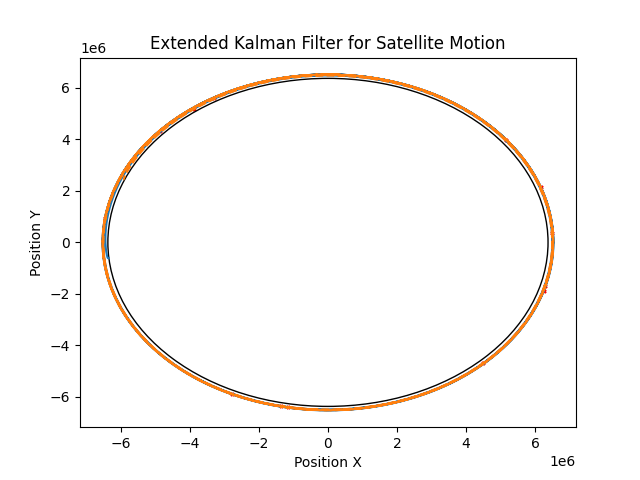

In [15]:
%matplotlib widget
true_traj = sim_data.state_array()[:, :2]

crash_coords = true_traj[-1, :]


fig, ax1 = plt.subplots()

plot_range = slice(0, 290925)

ax1.plot(true_traj[:, 0][plot_range], true_traj[:, 1][plot_range], label='True Trajectory')
ax1.scatter(measurements[:, 0][plot_range], measurements[:, 1][plot_range], marker='x', color='r', label='Noisy Measurements', s=5)
ax1.plot(estimated_traj[:, 0][plot_range], estimated_traj[:, 1][plot_range], label='EKF Estimated Trajectory', linestyle='--')
ax1.set_title('Extended Kalman Filter for Satellite Motion')
ax1.set_xlabel('Position X')
ax1.set_ylabel('Position Y')
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax1.add_patch(earth)



# ax2.plot(true_traj[:, 0], true_traj[:, 1], label='True Trajectory')
# ax2.scatter(measurements[:, 0], measurements[:, 1], marker='x', color='r', label='Noisy Measurements', s=1)
# ax2.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
# ax2.set_title('Extended Kalman Filter for Satellite Motion')
# ax2.set_xlabel('Position X')
# ax2.set_ylabel('Position Y')
# ax2.set_xlim([crash_coords[0]-4e5, crash_coords[0]+4e5])
# ax2.set_ylim([crash_coords[1]-4e5, crash_coords[1]+4e5])
# earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
# ax2.add_patch(earth)
# ax1.legend()

plt.show()